In [166]:
"""Basic script for loading the PROTEINS dataset and running training scrip with it.
To run it install pytorch for your OS and config from https://pytorch.org/get-started/locally/
and install PyG https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html"""

'Basic script for loading the PROTEINS dataset and running training scrip with it.\nTo run it install pytorch for your OS and config from https://pytorch.org/get-started/locally/\nand install PyG https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html'

In [167]:
"""Imports"""
import torch
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, BatchNorm
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch.nn import BCELoss
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from grph_conv import GCNConv, ChebConv, DConv, DCRNN

In [168]:
"""setting device on GPU if available, else CPU"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [169]:
"""Load the data, wrap it around DataLoader (utility that acts as batch generator).
Train/val split is done arbitrarely. This dataset does not contain edge features. Only 
Node features, edges and graph label."""

dataset_raw = TUDataset(root='', name='PROTEINS', use_node_attr=True, use_edge_attr=True)
indices = np.array(range(len(dataset_raw)))
val_indices = np.random.choice(range(len(dataset_raw)),replace=False,size=int(np.floor(len(dataset_raw)*0.2)))
train_indices = indices[[i for i in range(len(dataset_raw)) if i not in val_indices]]
train_ds = DataLoader(dataset_raw[train_indices], batch_size=32, shuffle=True)
val_ds = DataLoader(dataset_raw[val_indices], batch_size=32)

In [170]:
class GCN(torch.nn.Module):
    """Create GCN module. It is a neural network that accepts graphs of varying shapes as input, and returns 
    the label of a given graph (molecule or not). It is based on classic GCNConv, other methods has to be applied here."""
    def __init__(self, n_node_features, hidden_dim):
        super().__init__()
        self.conv1 = GCNConv(n_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim*2)
        self.conv3 = GCNConv(hidden_dim*2, hidden_dim*3)
        #self.conv4 = GCNConv(hidden_dim, hidden_dim)
        self.linear1 = torch.nn.Linear(hidden_dim*3, 512)
        self.linear2 = torch.nn.Linear(512, 128)
        self.linear3 = torch.nn.Linear(128, 1)
        self.dropout = torch.nn.Dropout()
    def forward(self, data):
        x, edge_index, batch_size = data.x, data.edge_index, data.batch
        x = F.normalize(x,dim=1)
        x = self.conv1(x, edge_index)
        x = BatchNorm(x.shape[1])(x)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = BatchNorm(x.shape[1])(x)
        x = F.leaky_relu(x)
        x = self.conv3(x, edge_index)
        x = BatchNorm(x.shape[1])(x)
        x = F.leaky_relu(x)
        #x = self.conv4(x, edge_index)
        x = global_mean_pool(x,batch_size)
        x = self.linear1(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        out = torch.sigmoid(x)
        return torch.squeeze(out)

In [171]:
class ChebNN(torch.nn.Module):
    """Create GCN module. It is a neural network that accepts graphs of varying shapes as input, and returns 
    the label of a given graph (molecule or not). It is based on classic GCNConv, other methods has to be applied here."""
    def __init__(self, n_node_features, hidden_dim):
        super().__init__()
        self.conv1 = ChebConv(n_node_features, hidden_dim,1)
        self.conv2 = ChebConv(hidden_dim, hidden_dim*2,1)
        self.conv3 = ChebConv(hidden_dim*2, hidden_dim*3,1)
        #self.conv4 = GCNConv(hidden_dim, hidden_dim)
        self.linear1 = torch.nn.Linear(hidden_dim*3, 512)
        self.linear2 = torch.nn.Linear(512, 128)
        self.linear3 = torch.nn.Linear(128, 1)
        self.dropout = torch.nn.Dropout()
    def forward(self, data):
        x, edge_index, batch_size = data.x, data.edge_index, data.batch
        
        x = F.normalize(x,dim=1)
        x = self.conv1(x, edge_index)
        x = BatchNorm(x.shape[1])(x)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index)
        x = BatchNorm(x.shape[1])(x)
        x = F.leaky_relu(x)
        x = self.conv3(x, edge_index)
        x = BatchNorm(x.shape[1])(x)
        x = F.leaky_relu(x)
        #x = self.conv4(x, edge_index)
        x = global_mean_pool(x,batch_size)
        x = self.linear1(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        out = torch.sigmoid(x)
        return torch.squeeze(out)

In [172]:
class DConvNN(torch.nn.Module):
    """Create GCN module. It is a neural network that accepts graphs of varying shapes as input, and returns 
    the label of a given graph (molecule or not). It is based on classic GCNConv, other methods has to be applied here."""
    def __init__(self, n_node_features, hidden_dim):
        super().__init__()
        self.conv1 = DConv(n_node_features, hidden_dim,1)
        self.conv2 = DConv(hidden_dim, hidden_dim*2,1)
        self.conv3 = DConv(hidden_dim*2, hidden_dim*3,1)
        #self.conv4 = GCNConv(hidden_dim, hidden_dim)
        self.linear1 = torch.nn.Linear(hidden_dim*3, 512)
        self.linear2 = torch.nn.Linear(512, 128)
        self.linear3 = torch.nn.Linear(128, 1)
        self.dropout = torch.nn.Dropout()
    def forward(self, data):
        x, edge_index, batch_size = data.x, data.edge_index, data.batch
        edge_weights = torch.ones(size=[edge_index.shape[1]])
        x = F.normalize(x,dim=1)
        x = self.conv1(x, edge_index,edge_weights)
        x = BatchNorm(x.shape[1])(x)
        x = F.leaky_relu(x)
        x = self.conv2(x, edge_index,edge_weights)
        x = BatchNorm(x.shape[1])(x)
        x = F.leaky_relu(x)
        x = self.conv3(x, edge_index,edge_weights)
        x = BatchNorm(x.shape[1])(x)
        x = F.leaky_relu(x)
        #x = self.conv4(x, edge_index)
        x = global_mean_pool(x,batch_size)
        x = self.linear1(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        out = torch.sigmoid(x)
        return torch.squeeze(out)

In [173]:
def check_accuracy(data_loader, model):
  num_correct = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for data in data_loader:
        data.to(device)
        scores = model(data)
        predictions = (scores > 0.5).long()
        num_correct += (predictions == data.y).sum()
        num_samples += predictions.size(0)
        accuracy = float(num_correct)/float(num_samples)*100

  model.train()
  
  return accuracy

In [174]:

def get_accuracy(y_true, y_prob):
    """Binary accuracy calculation"""
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.5, 0, y_prob)
    y_prob = np.where(y_prob > 0.5, 1, y_prob)

    accuracy = metrics.accuracy_score(y_true, y_prob)
    return accuracy

Epoch 0, loss (normalized): 0.645442145211356, accuracy: 0.6419753086419753
Epoch 0, val loss (normalized): 0.6364739962986538, accuracy: 0.6296296296296297
Epoch 1, loss (normalized): 0.5829759325299945, accuracy: 0.67003367003367
Epoch 1, val loss (normalized): 0.6214709963117327, accuracy: 0.7037037037037037
Epoch 2, loss (normalized): 0.5661111899784633, accuracy: 0.6805087916199027
Epoch 2, val loss (normalized): 0.601954596383231, accuracy: 0.654320987654321
Epoch 3, loss (normalized): 0.5679208891732352, accuracy: 0.6910774410774411
Epoch 3, val loss (normalized): 0.5938359669276646, accuracy: 0.6666666666666666
Epoch 4, loss (normalized): 0.5512522288731166, accuracy: 0.7007856341189674
Epoch 4, val loss (normalized): 0.6059261049543109, accuracy: 0.674074074074074
Epoch 5, loss (normalized): 0.5470355919429234, accuracy: 0.7065095398428731
Epoch 5, val loss (normalized): 0.5799837112426758, accuracy: 0.691358024691358
Epoch 6, loss (normalized): 0.5330616406032017, accuracy: 0

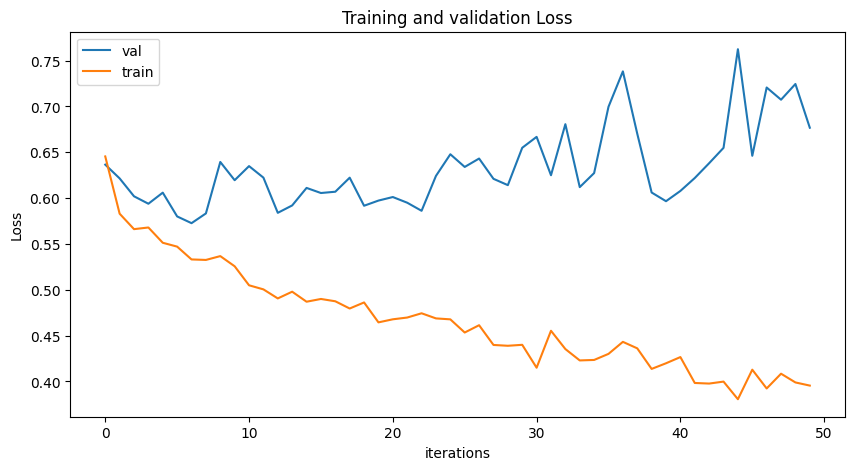

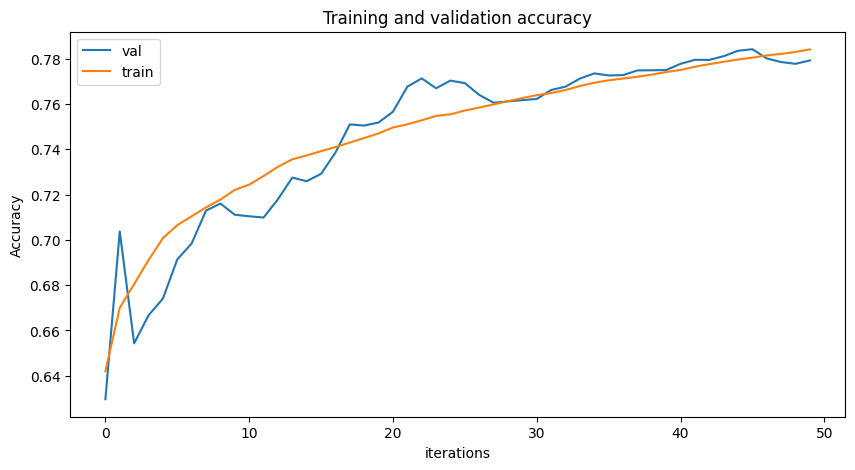

In [176]:
"""Train results for GCN"""
"""Train the model on the training data. Parameters are updated per batch.
WARNING! For batch size of 1 user probably will need to torch.squeeze data.y"""
"""Initializing the network and optimizer. For debugging purposes the network runs on CPU."""
model = GCN(dataset_raw.num_node_features, 16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

epochs_num = 50
preds = []
ground_truth = []
preds_valid = []
ground_truth_valid = []
val_len = len(val_ds)
train_len = len(train_ds)
train_losses =[]
val_losses = []
train_acc = []
val_acc = []

for epoch in range(epochs_num):
    epoch_loss = 0.0
    epoch_loss_valid = 0.0
    for data in train_ds:
        optimizer.zero_grad()
        data.to(device)
        y_hat = model(data)
        preds.extend(y_hat.detach().numpy())
        ground_truth.extend(data.y.numpy())
        loss = BCELoss()(y_hat, data.y.to(torch.float32))
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    

    acc = get_accuracy(ground_truth,preds)
    print(f"Epoch {epoch}, loss (normalized): {epoch_loss.item() / train_len}, accuracy: {acc}")
    train_losses.append(epoch_loss.item() / train_len)
    train_acc.append(acc)
    
    model.eval()
    
    with torch.no_grad():
        
        for data_val in val_ds:
            data_val.to(device)
            y_hat_val = model(data_val)
            preds_valid.extend(y_hat.detach().numpy())
            ground_truth_valid.extend(data.y.numpy())
            loss_val = BCELoss()(y_hat_val, data_val.y.to(torch.float32))
            epoch_loss_valid += loss_val
        
        
        acc = get_accuracy(ground_truth_valid,preds_valid)
        print(f"Epoch {epoch}, val loss (normalized): {epoch_loss_valid.item() / val_len}, accuracy: {acc}")
        val_losses.append(epoch_loss_valid.item() / val_len)
        val_acc.append(acc)
        
    model.train()

"""Plotting train and validation loss"""

plt.figure(figsize=(10,5))
plt.title("Training and validation Loss")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

"""Plotting train and validation accuracy"""

plt.figure(figsize=(10,5))
plt.title("Training and validation accuracy")
plt.plot(val_acc, label="val")
plt.plot(train_acc, label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 0, loss (normalized): 0.6720842633928571, accuracy: 0.622895622895623
Epoch 0, val loss (normalized): 0.6617007255554199, accuracy: 0.5555555555555556
Epoch 1, loss (normalized): 0.6307189123971122, accuracy: 0.6515151515151515
Epoch 1, val loss (normalized): 0.6287597928728376, accuracy: 0.5740740740740741
Epoch 2, loss (normalized): 0.6073685373578753, accuracy: 0.6636737747848859
Epoch 2, val loss (normalized): 0.5887033598763602, accuracy: 0.5925925925925926
Epoch 3, loss (normalized): 0.5780954360961914, accuracy: 0.6734006734006734
Epoch 3, val loss (normalized): 0.5708056518009731, accuracy: 0.6018518518518519
Epoch 4, loss (normalized): 0.5502667086465018, accuracy: 0.683726150392817
Epoch 4, val loss (normalized): 0.5884651456560407, accuracy: 0.6444444444444445
Epoch 5, loss (normalized): 0.5391112395695278, accuracy: 0.6937897493453049
Epoch 5, val loss (normalized): 0.5682013375418526, accuracy: 0.6666666666666666
Epoch 6, loss (normalized): 0.5492925984518868, accura

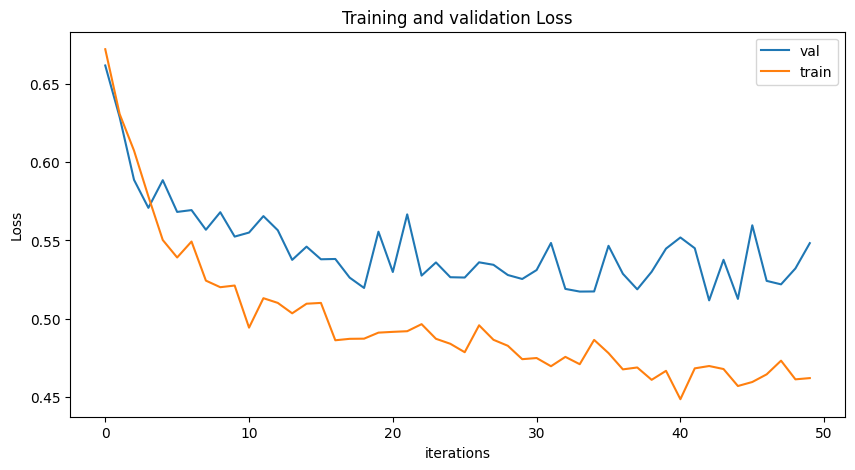

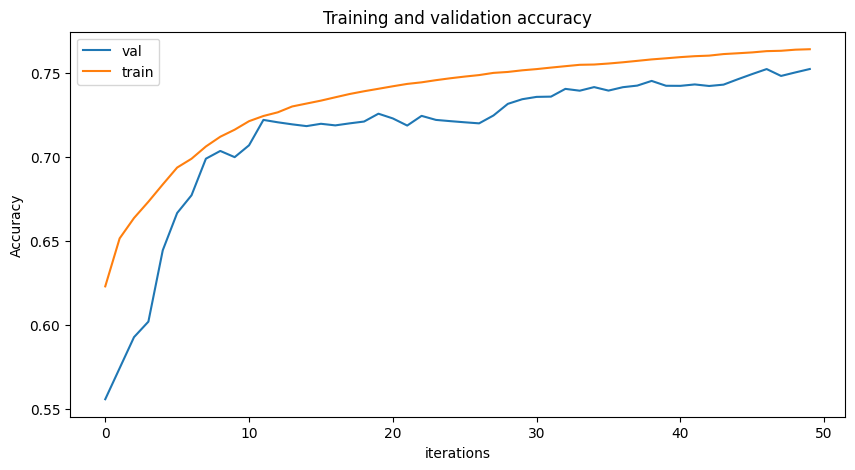

In [178]:
"""Train results for ChebConv"""
"""Train the model on the training data. Parameters are updated per batch.
WARNING! For batch size of 1 user probably will need to torch.squeeze data.y"""
"""Initializing the network and optimizer. For debugging purposes the network runs on CPU."""
model = ChebNN(dataset_raw.num_node_features, 16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

epochs_num = 50
preds = []
ground_truth = []
preds_valid = []
ground_truth_valid = []
val_len = len(val_ds)
train_len = len(train_ds)
train_losses =[]
val_losses = []
train_acc = []
val_acc = []

for epoch in range(epochs_num):
    epoch_loss = 0.0
    epoch_loss_valid = 0.0
    for data in train_ds:
        optimizer.zero_grad()
        data.to(device)
        y_hat = model(data)
        preds.extend(y_hat.detach().numpy())
        ground_truth.extend(data.y.numpy())
        loss = BCELoss()(y_hat, data.y.to(torch.float32))
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    

    acc = get_accuracy(ground_truth,preds)
    print(f"Epoch {epoch}, loss (normalized): {epoch_loss.item() / train_len}, accuracy: {acc}")
    train_losses.append(epoch_loss.item() / train_len)
    train_acc.append(acc)
    
    model.eval()
    
    with torch.no_grad():
        
        for data_val in val_ds:
            data_val.to(device)
            y_hat_val = model(data_val)
            preds_valid.extend(y_hat.detach().numpy())
            ground_truth_valid.extend(data.y.numpy())
            loss_val = BCELoss()(y_hat_val, data_val.y.to(torch.float32))
            epoch_loss_valid += loss_val
        
        
        acc = get_accuracy(ground_truth_valid,preds_valid)
        print(f"Epoch {epoch}, val loss (normalized): {epoch_loss_valid.item() / val_len}, accuracy: {acc}")
        val_losses.append(epoch_loss_valid.item() / val_len)
        val_acc.append(acc)
        
    model.train()

"""Plotting train and validation loss"""

plt.figure(figsize=(10,5))
plt.title("Training and validation Loss")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

"""Plotting train and validation accuracy"""

plt.figure(figsize=(10,5))
plt.title("Training and validation accuracy")
plt.plot(val_acc, label="val")
plt.plot(train_acc, label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Epoch 0, loss (normalized): 0.6631734030587333, accuracy: 0.6071829405162739
Epoch 0, val loss (normalized): 0.6707871300833566, accuracy: 0.5925925925925926
Epoch 1, loss (normalized): 0.6059917041233608, accuracy: 0.6380471380471381
Epoch 1, val loss (normalized): 0.5956882749285016, accuracy: 0.6111111111111112
Epoch 2, loss (normalized): 0.5559458392007011, accuracy: 0.6674148896371118
Epoch 2, val loss (normalized): 0.6499125616891044, accuracy: 0.654320987654321
Epoch 3, loss (normalized): 0.5516636371612549, accuracy: 0.6840628507295174
Epoch 3, val loss (normalized): 0.5754547800336566, accuracy: 0.7037037037037037
Epoch 4, loss (normalized): 0.5374804564884731, accuracy: 0.6938271604938272
Epoch 4, val loss (normalized): 0.6131705556597028, accuracy: 0.725925925925926
Epoch 5, loss (normalized): 0.5368817533765521, accuracy: 0.7025813692480359
Epoch 5, val loss (normalized): 0.5539671352931431, accuracy: 0.7222222222222222
Epoch 6, loss (normalized): 0.5129091399056571, accura

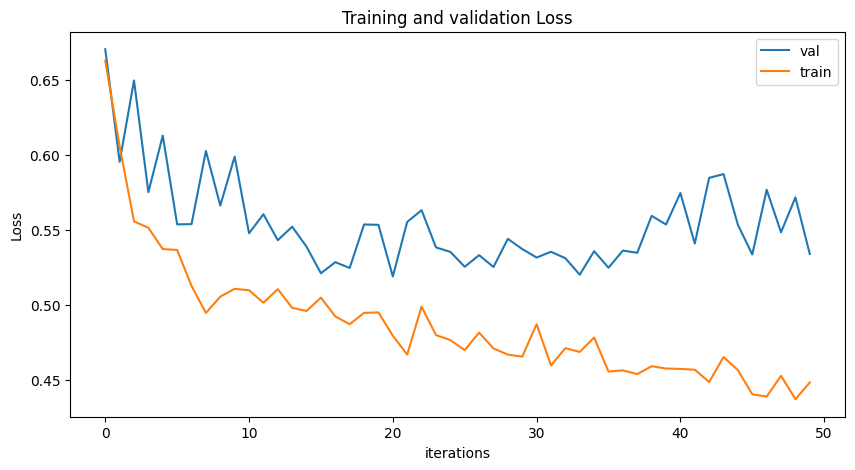

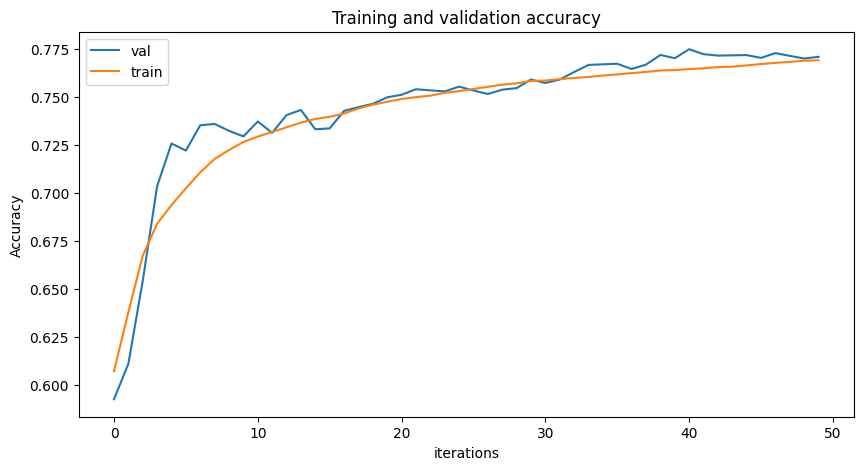

In [179]:
"""Train results for Dconv"""
"""Train the model on the training data. Parameters are updated per batch.
WARNING! For batch size of 1 user probably will need to torch.squeeze data.y"""
"""Initializing the network and optimizer. For debugging purposes the network runs on CPU."""
model = DConvNN(dataset_raw.num_node_features, 16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

epochs_num = 50
preds = []
ground_truth = []
preds_valid = []
ground_truth_valid = []
val_len = len(val_ds)
train_len = len(train_ds)
train_losses =[]
val_losses = []
train_acc = []
val_acc = []

for epoch in range(epochs_num):
    epoch_loss = 0.0
    epoch_loss_valid = 0.0
    for data in train_ds:
        optimizer.zero_grad()
        data.to(device)
        y_hat = model(data)
        preds.extend(y_hat.detach().numpy())
        ground_truth.extend(data.y.numpy())
        loss = BCELoss()(y_hat, data.y.to(torch.float32))
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    

    acc = get_accuracy(ground_truth,preds)
    print(f"Epoch {epoch}, loss (normalized): {epoch_loss.item() / train_len}, accuracy: {acc}")
    train_losses.append(epoch_loss.item() / train_len)
    train_acc.append(acc)
    
    model.eval()
    
    with torch.no_grad():
        
        for data_val in val_ds:
            data_val.to(device)
            y_hat_val = model(data_val)
            preds_valid.extend(y_hat.detach().numpy())
            ground_truth_valid.extend(data.y.numpy())
            loss_val = BCELoss()(y_hat_val, data_val.y.to(torch.float32))
            epoch_loss_valid += loss_val
        
        
        acc = get_accuracy(ground_truth_valid,preds_valid)
        print(f"Epoch {epoch}, val loss (normalized): {epoch_loss_valid.item() / val_len}, accuracy: {acc}")
        val_losses.append(epoch_loss_valid.item() / val_len)
        val_acc.append(acc)
        
    model.train()

"""Plotting train and validation loss"""

plt.figure(figsize=(10,5))
plt.title("Training and validation Loss")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

"""Plotting train and validation accuracy"""

plt.figure(figsize=(10,5))
plt.title("Training and validation accuracy")
plt.plot(val_acc, label="val")
plt.plot(train_acc, label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
"""Plotting train and validation loss"""

plt.figure(figsize=(10,5))
plt.title("Training and validation Loss")
plt.plot(val_losses, label="val")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
"""Plotting train and validation accuracy"""

plt.figure(figsize=(10,5))
plt.title("Training and validation accuracy")
plt.plot(val_acc, label="val")
plt.plot(train_acc, label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()